- Need to predict the time until the quake occurs
- Training data comes from one experiment but Test data has data from many experiments.
- The submission files should have seg_id column and time_to_quake columns(target_variable).



In [0]:
# Dependencies
!pip install kaggle
!pip install numpy
!pip install catboost


In [0]:
# Modules
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

In [0]:
# import dataset from kaggle
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [0]:
!kaggle competitions download -c LANL-Earthquake-Prediction

In [0]:
!ls

catboost.csv	       seg_003339.csv  seg_006e4a.csv  seg_00f3b9.csv
catboost_info	       seg_0042cc.csv  seg_007a37.csv  seg_010eab.csv
sample_data	       seg_004314.csv  seg_00a37e.csv  seg_0125d9.csv
sample_submission.csv  seg_004cd2.csv  seg_00be11.csv  test_data
seg_00030f.csv	       seg_004ee5.csv  seg_00c35b.csv  train.csv.zip
seg_0012b5.csv	       seg_004f1f.csv  seg_00cc91.csv
seg_00184e.csv	       seg_00648a.csv  seg_00e5f7.csv


In [0]:
!unzip test.zip
!cd test/
!ls -al | wc -l

In [91]:
file_count = 0
for fil in os.listdir("/content/test/"):
  file_count +=1
print(file_count)

2624


In [0]:
# since files is very large (8.9GB) we can read fized no of rows using nrows argument
train = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [0]:
#print first 10 entries
train.head(10)



,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


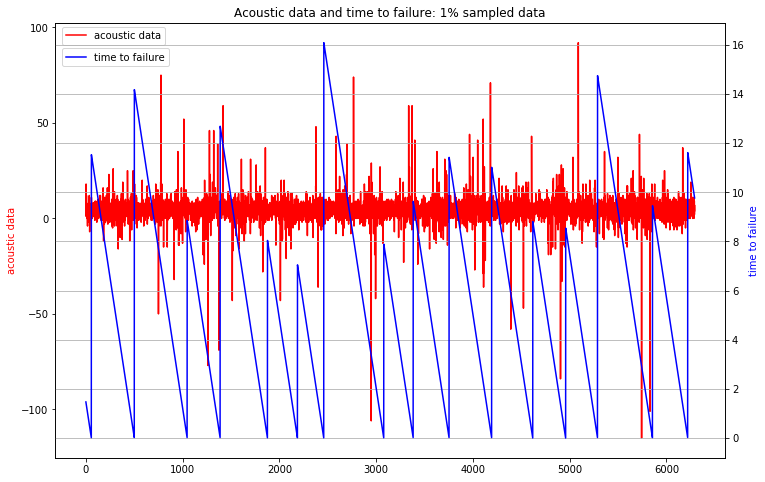

In [0]:
## visualizng the data
train_ad_sample_df = train['acoustic_data'].values[:1000000000:100000]
train_ttf_sample_df = train['time_to_failure'].values[:1000000000:100000]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [0]:
# Since Its a time series data we have to generate some feature for e.g statistical features
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)



In [0]:
# Applying features method on every 150000 rows and creating the df 
train = pd.read_csv('train.csv', iterator=True, chunksize=150000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for chunk_df in train:
  row = gen_features(chunk_df['acoustic_data'])
  X_train = X_train.append(row, ignore_index=True)
  y_train = y_train.append(pd.Series(chunk_df['time_to_failure'].values[-1]))

    

## Implementing Catboost model(A type of Gradient Boosting)

- Gradient boosting on decision trees is a form of machine learning that works by progressively training more complex models to maximize the accuracy of predictions. 

- It's one of the most efficient ways to build ensemble models. The combination of gradient boosting with decision trees provides state-of-the-art results in many applications with structured data.

- First, tree is build wiht some error. Second, a new tree is build to reduce the error made by the first tree.

- The algorithm repeats itself until it builds a decent model.

- It’s not a good idea to build very big trees in boosting since they overfit the data.



In [0]:
train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)


In [0]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,4.884113,5.101106,-98.0,104.0,33.662481,-0.024061,-8.0,-2.0,11.0,18.0,104.0,5.576567,4.333325
1,4.725767,6.588824,-154.0,181.0,98.758517,0.390561,-11.0,-2.0,12.0,21.0,181.0,5.734167,5.732777
2,4.906393,6.967397,-106.0,140.0,33.555211,0.217391,-15.0,-3.0,13.0,26.0,140.0,6.152647,5.895945
3,4.902240,6.922305,-199.0,197.0,116.548172,0.757278,-12.0,-2.0,12.0,22.0,199.0,5.933960,6.061214
4,4.908720,7.301110,-126.0,145.0,52.977905,0.064531,-15.0,-2.0,12.0,26.0,145.0,6.110587,6.329485


In [0]:
import os
final_list = []
for fil in os.listdir("/content/test"):
  df = pd.read_csv("/content/test/"+fil)
  check = pd.DataFrame()
  row = gen_features(df['acoustic_data'])
  check = check.append(row, ignore_index=True)
  ttf = m.predict(check)
  final_list.append([fil,ttf[0]])

In [93]:
len(final_list)

2624

In [0]:
su = pd.DataFrame.from_records(final_list)


In [95]:
su.head()

,0,1
0,seg_d9b162.csv,7.005325
1,seg_fe73b1.csv,9.626789
2,seg_41aadc.csv,8.473043
3,seg_ef9105.csv,10.487996
4,seg_81a8ea.csv,10.033719


In [0]:
su.columns = ['seg_id','time_to_failure']

In [97]:
su.dtypes

seg_id              object
time_to_failure    float64
dtype: object

In [0]:
su["time_to_failure"] = su["time_to_failure"].astype(np.int16)

In [99]:
su.head()

,seg_id,time_to_failure
0,seg_d9b162.csv,7
1,seg_fe73b1.csv,9
2,seg_41aadc.csv,8
3,seg_ef9105.csv,10
4,seg_81a8ea.csv,10


In [0]:
su["seg_id"] = su["seg_id"].apply(lambda x : x[:-4])

In [103]:
su.head()

,seg_id,time_to_failure
0,seg_d9b162,7
1,seg_fe73b1,9
2,seg_41aadc,8
3,seg_ef9105,10
4,seg_81a8ea,10


In [0]:
su.to_csv("/content/catboost.csv",index = False)